# Data Mining - Assignment 2 (Text Mining and NLP)

For this assignment we have to do a Sentiment Analysis using Tweets that can be classified as positive (4) or negative (1). 

### 1. Load Data

In [4]:
import pandas as pd
all_data = pd.read_csv('training.1600000.processed.noemoticon.csv', header= None, encoding='Windows-1252')

Since the .csv file has 1600000 rows we are just using a fraction of the data, to make the analysis faster and more suitable for the assignment.

In [6]:
data = all_data.sample(frac=0.05, random_state=42)

The .csv file does not contain any column names therefor we need to specifiy them and reset the index that were changed due to the random sampling.

In [8]:
data.columns = ["target", "ids", "date", "flag", "user", "text"]

In [9]:
data = data.reset_index(drop = True)

In [10]:
data

,target,ids,date,flag,user,text
0,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
1,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
2,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
3,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
4,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem
...,...,...,...,...,...,...
79995,0,2008519305,Tue Jun 02 14:15:04 PDT 2009,NO_QUERY,annie_escape,james lafferty is in chicago right now.. wah i...
79996,4,1574064694,Tue Apr 21 04:06:09 PDT 2009,NO_QUERY,elainebenter,"oh, i got followers! awesome"
79997,4,1997083232,Mon Jun 01 16:13:22 PDT 2009,NO_QUERY,18percentgrey,@ShellyKramer Cadillac Chris is a true GRILL M...
79998,4,2001053490,Mon Jun 01 23:42:22 PDT 2009,NO_QUERY,SUGARvampchick,@thexartiste i know me too. i should be asleep...


### 2. Exploratory Data Analysis

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  80000 non-null  int64 
 1   ids     80000 non-null  int64 
 2   date    80000 non-null  object
 3   flag    80000 non-null  object
 4   user    80000 non-null  object
 5   text    80000 non-null  object
dtypes: int64(2), object(4)
memory usage: 3.7+ MB


In this dataset there are only two columns that are of interest to us; the target and the text column. The others can be ignored.

In [14]:
duplicated_rows = data[data.duplicated(keep=False)]
print(f'Number of duplicated rows: {len(duplicated_rows)}')

Number of duplicated rows: 0


There are no duplicated rows, therefore we can continue with the visualization of our numerical value column.

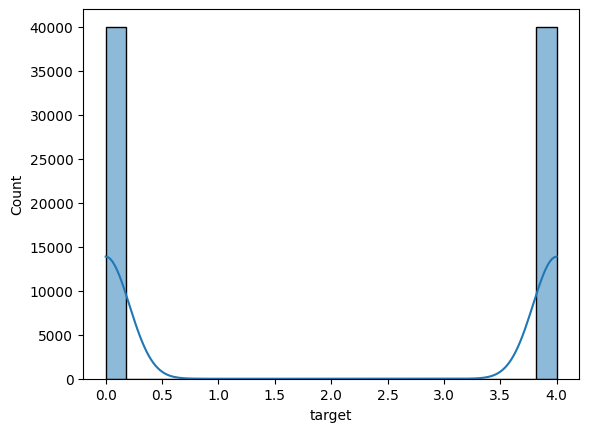

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data['target'], kde=True)
plt.show()

In [17]:
data['target'].value_counts()

target
4    40001
0    39999
Name: count, dtype: int64

The target column has almost the same amount of positive and negative tweets, which is necessary for a good training outcome.

### 3. Data Preprocessing

#### 3.1 Missing values

In [21]:
data.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

There are no missing values in the two dataset.

#### 3.2 Feature Engineering

In [24]:
import re
import unicodedata

The names of the people that have been tagged in a tweet are unimortant therefore they need to be removed:

In [26]:
def removenames(x):
    return re.sub(r'(@[a-z0-9+._-]+)',"", x)

The link to webpages are unimportant as well since they do not represent any emotion:

In [28]:
def removeUrls(x):
    return re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , x)

The retweets need to be removed since they have nothing to do with the emotional message that the person wants to bring across:

In [30]:
def removeRt(x):
    return re.sub(r'\brt\b', '', x).strip()

The special characters need to be removed since these have no meaning that could be classified as positive or negative:

In [32]:
def removeSpecialChars(x):
    x = re.sub(r'[^\w ]+', "", x)
    x = ' '.join(x.split())
    return x

The special characters like ä, ö or ü for example will be ignored and turned into a, o, u:

In [34]:
def removeAccentedChars(x):
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return x

We also need to remove all the words that are unimportant for our analysis because they are stopwords like and, but, the, etc.:

In [36]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def removeStopwords(x):
    return ' '.join([t for t in x.split() if t not in stop_words])

The next function removes characters that are repeated more than twice:  

In [38]:
def removeDupsChar(x):
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x

To clean the data we can create a big function that contains all the small functions required for the Data Cleaning:

In [40]:
def dataClean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = removeStopwords(x)
    x = removenames(x)
    x = removeUrls(x)
    x = removeRt(x)
    x = removeDupsChar(x)
    x = removeAccentedChars(x)
    x = removeSpecialChars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x

Now we can use this big funtion and let it run through every row of the text column:

In [42]:
for i in range(len(data['text'])):
    data.loc[i, 'text'] = dataClean(data.loc[i, 'text'])

#### 3.3 Tokenization

Tokenization is there to split the sentences into a list of words that is needed for the further analysis:

In [45]:
from nltk.tokenize import word_tokenize

In [46]:
data['text'] = data['text'].str.lower()

In [47]:
data['tokens'] = data['text'].apply(word_tokenize)

#### 3.4 Stemming

This action changes the words to umbrella terms so the different versions are seen as the same word. It eliminates prefixes and suffixes from words, transforming them into their fundamental or root form.

In [50]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

# Apply stemming
data['tokens'] = data['tokens'].apply(
    lambda x: [stemmer.stem(word) for word in x]
)

In [51]:
data

,target,ids,date,flag,user,text,tokens
0,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,ah hope ok,"[ah, hope, ok]"
1,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,cool tweet apps razr 2,"[cool, tweet, app, razr, 2]"
2,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,know family drama lamehey next time u hang kim...,"[know, famili, drama, lamehey, next, time, u, ..."
3,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,school email open geography stuff revise stupi...,"[school, email, open, geographi, stuff, revis,..."
4,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem,"[upper, airway, problem]"
...,...,...,...,...,...,...,...
79995,0,2008519305,Tue Jun 02 14:15:04 PDT 2009,NO_QUERY,annie_escape,james lafferty chicago right now wah wanna go lol,"[jame, lafferti, chicago, right, now, wah, wan..."
79996,4,1574064694,Tue Apr 21 04:06:09 PDT 2009,NO_QUERY,elainebenter,oh got followers awesome,"[oh, got, follow, awesom]"
79997,4,1997083232,Mon Jun 01 16:13:22 PDT 2009,NO_QUERY,18percentgrey,cadillac chris true grill master he,"[cadillac, chri, true, grill, master, he]"
79998,4,2001053490,Mon Jun 01 23:42:22 PDT 2009,NO_QUERY,SUGARvampchick,know too asleep chathe nice guy,"[know, too, asleep, chath, nice, guy]"


#### 3.5 Visualization

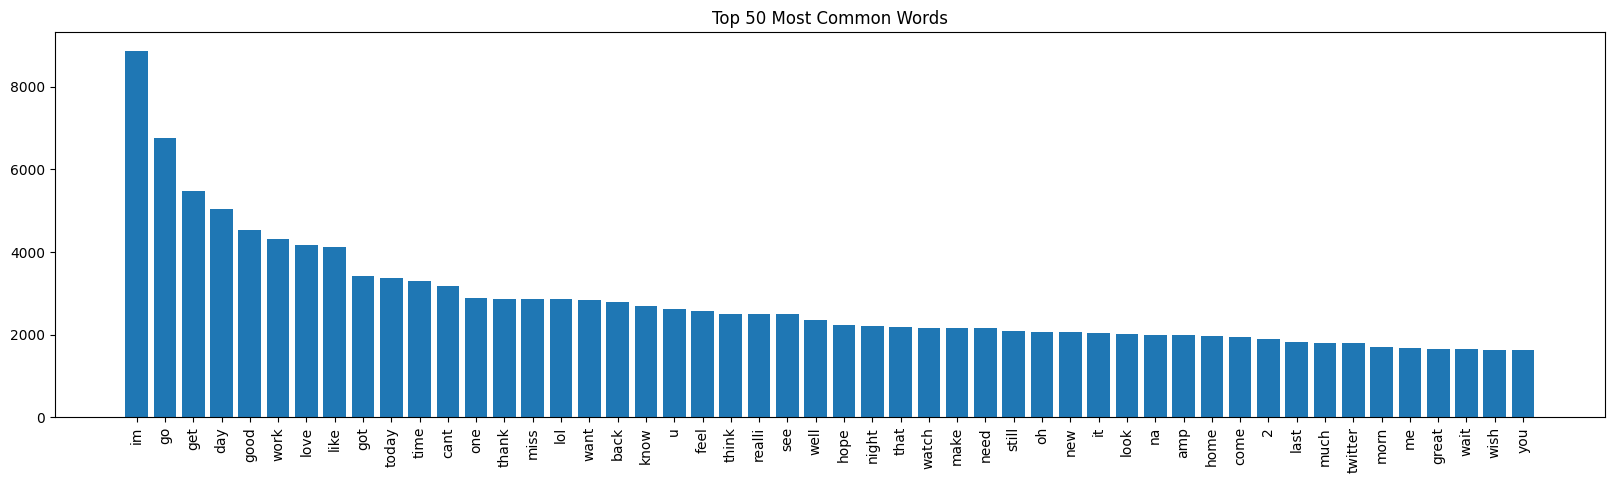

In [53]:
from collections import Counter
import matplotlib.pyplot as plt

# Flatten the list of all tokens
all_words = [word for tokens in data['tokens'] for word in tokens]

# Count word frequencies
word_freq = Counter(all_words)
common_words = word_freq.most_common(50)  # Top 50 words

# Plot word frequencies
words, counts = zip(*common_words)
plt.figure(figsize=(20, 5))
plt.bar(words, counts)
plt.xticks(rotation=90)
plt.title("Top 50 Most Common Words")
plt.show()

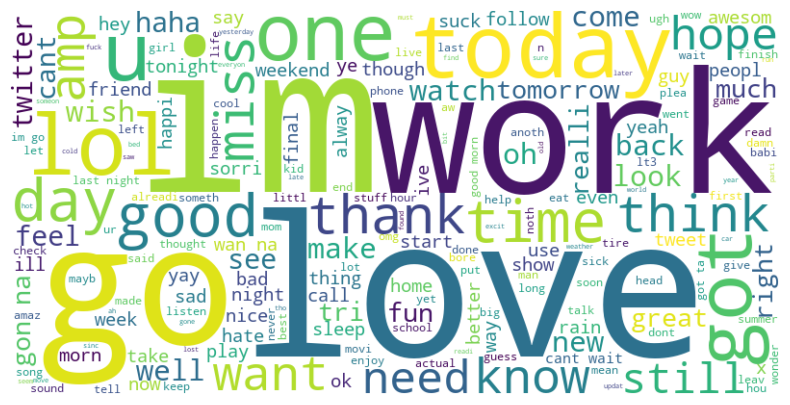

In [54]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(all_words))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### 4. Build a BOW (Bag of Words)

First we have to split the data in training and test data.

In [57]:
from sklearn.model_selection import train_test_split

X = data['tokens']  
Y = data['target']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [58]:
Y_train

3822     4
35562    4
4883     0
71170    0
25665    0
        ..
6265     0
54886    0
76820    4
860      4
15795    0
Name: target, Length: 64000, dtype: int64

Since we have a binary target variable we need to use 0 and 1 for the code to work properly instead of 0 and 4.

In [60]:
Y_train = (Y_train == 4).astype(int)
Y_test = (Y_test == 4).astype(int)

In [61]:
Y_train

3822     1
35562    1
4883     0
71170    0
25665    0
        ..
6265     0
54886    0
76820    1
860      1
15795    0
Name: target, Length: 64000, dtype: int64

Countvectorizer is used to transform the text tokens into a vector on the basis of the frequency (count) of each word that occurs in the tokens. This is done because numerical values are needed to perform the calculations needed for the use of algorithms.

In [63]:
from sklearn.feature_extraction.text import CountVectorizer

x_train = [' '.join(doc) for doc in X_train]
x_test = [' '.join(doc) for doc in X_test]

vectorizer = CountVectorizer()

x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

### 5. Train Models

#### 5.1 KNN

In [66]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier()
KNN.fit(x_train, Y_train)

KNN.score(x_test, Y_test)

0.667375

#### 5.2 Decision Tree

In [68]:
from sklearn import tree

Decision_Tree = tree.DecisionTreeClassifier(random_state=42)
Decision_Tree.fit(x_train, Y_train)

Decision_Tree.score(x_test, Y_test)

0.6875625

#### 5.3 SVM

In [70]:
from sklearn.svm import SVC

SVM = SVC(random_state=42)
SVM.fit(x_train, Y_train)

SVM.score(x_test, Y_test)

0.762

### 6. Model Evaluation

In [131]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from prettytable import PrettyTable

myTable = PrettyTable(["Model", "Accuracy", "Precision", "Recall", "F1-Score", "Confusion Matrix"])

models = [KNN, Decision_Tree, SVM]
models_name = ['KNN', 'Decision_Tree', 'SVM']

for model in models:
    y_pred = model.predict(x_test)
       
    accuracy = accuracy_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred)
    recall = recall_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)
    cm = confusion_matrix(Y_test, y_pred)
    
    x = models.index(model)

    myTable.add_row([models_name[x], accuracy, precision, recall, f1, cm])

print(myTable)

+---------------+-----------+--------------------+--------------------+--------------------+------------------+
|     Model     |  Accuracy |     Precision      |       Recall       |      F1-Score      | Confusion Matrix |
+---------------+-----------+--------------------+--------------------+--------------------+------------------+
|      KNN      |  0.667375 | 0.6589368533713879 | 0.6930581613508443 | 0.6755669348939283 |   [[5137 2868]   |
|               |           |                    |                    |                    |   [2454 5541]]   |
| Decision_Tree | 0.6875625 | 0.6946465696465697 | 0.6686679174484053 | 0.6814097253202472 |   [[5655 2350]   |
|               |           |                    |                    |                    |   [2649 5346]]   |
|      SVM      |   0.762   | 0.7463230968349217 | 0.7933708567854909 | 0.7691281678186007 |   [[5849 2156]   |
|               |           |                    |                    |                    |   [1652 634

It is clear to see that the SVM performs the best and the KNN is the worst model of these three. The Confusion Matrix indicates that there is no overfitting and most of the datapoints are classified correctly. 

### 7. CNN

#### 7.1 Import Libraries and set Parameters

In [76]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

embedding_dim = 100
max_length = 1600
num_words = 5000

#### 7.2 Load GloVe

In [78]:
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f: 
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

#### 7.3 Tokenizer and Padding sequences

By using a tokenizer and padding sequences, we can effectively preprocess text data, making it suitable for training the CNN.

In [81]:
# Tokenizer setup
tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(data['tokens'])

# Convert text to sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train = pad_sequences(X_train, maxlen=max_length, padding="post", truncating="post")
X_test = pad_sequences(X_test, maxlen=max_length, padding="post", truncating="post")

#### 7.4 Embedding Matrix

The Embedding Matrix maps each word in the vocabulary to a dense vector of fixed size, capturing semantic relationships between words.

In [84]:
word_index = tokenizer.word_index
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < num_words:  
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

#### 7.5 CNN Design

* Embedding Layer: Converts words into dense vectors using pre-trained GloVe embeddings.

* Conv1D Layer: Applies 1D convolution with 128 filters and a kernel size of 5, using ReLU activation to capture local patterns in the text.

* GlobalMaxPooling1D Layer: Reduces the output from the convolutional layer by taking the maximum value from each feature map, creating a fixed-size output.

* Dropout Layers: Adds dropout with a rate of 0.5 to prevent overfitting by randomly setting half of the input units to zero during training.

* Dense Layers: Includes a fully connected layer with 64 units and ReLU activation, followed by another dropout layer, and finally a dense layer with a single unit and sigmoid activation for binary classification.

* Compilation: Compiles the model using the Adam optimizer and binary cross-entropy loss, with accuracy as the evaluation metric.


In [87]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

CNN = Sequential()
CNN.add(Embedding(input_dim=num_words,  # Size of the vocabulary
                  output_dim=embedding_dim,  # GloVe embedding dimensions
                  weights=[embedding_matrix],  # Load pre-trained GloVe embeddings
                  input_length=max_length,  # Max sequence length
                  trainable=False)) 
CNN.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
CNN.add(GlobalMaxPooling1D())
CNN.add(Dropout(0.5))
CNN.add(Dense(64, activation='relu'))
CNN.add(Dropout(0.5))
CNN.add(Dense(1, activation='sigmoid'))  

CNN.compile(optimizer='adam',
              loss='binary_crossentropy',  
              metrics=['accuracy'])

C:\Users\Kim_W\DS_Assignment2\dsassignment2\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


#### 7.6 Train Model

* EarlyStopping: Monitors the validation loss during training and stops the training process if the loss does not improve for a specified number of epochs (patience=1).

* Model Training: Trains the CNN model for up to 10 epochs, using a batch size of 32 and a validation split of 20%, with early stopping to prevent overfitting.



In [90]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

CNN.fit(X_train, Y_train,
                epochs=10,
                batch_size=32,
                validation_split=0.2,
                callbacks=[early_stopping])

Epoch 1/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 504s 312ms/step - accuracy: 0.5892 - loss: 0.6742 - val_accuracy: 0.6894 - val_loss: 0.5816
Epoch 2/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 512s 318ms/step - accuracy: 0.6796 - loss: 0.5904 - val_accuracy: 0.6979 - val_loss: 0.5754
Epoch 3/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 559s 316ms/step - accuracy: 0.6997 - loss: 0.5710 - val_accuracy: 0.7088 - val_loss: 0.5646
Epoch 4/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 494s 309ms/step - accuracy: 0.7134 - loss: 0.5491 - val_accuracy: 0.7127 - val_loss: 0.5594
Epoch 5/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 491s 307ms/step - accuracy: 0.7225 - loss: 0.5456 - val_accuracy: 0.7157 - val_loss: 0.5519
Epoch 6/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 504s 308ms/step - accuracy: 0.7307 - loss: 0.5304 - val_accuracy: 0.7130 - val_loss: 0.5521


We can see that the accuracy increases with every epoch. At the end it is quite high with 73.1% for the validation data.

### 8. Model Comparison

In [93]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from prettytable import PrettyTable

pred = CNN.predict(X_test)
y_pred = (pred > 0.5).astype(int)


accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
cm = confusion_matrix(Y_test, y_pred)

myTable.add_row(['CNN', accuracy, precision, recall, f1, cm])

print(myTable)

500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 76ms/step
+---------------+-----------+--------------------+--------------------+--------------------+------------------+
|     Model     |  Accuracy |     Precision      |       Recall       |      F1-Score      | Confusion Matrix |
+---------------+-----------+--------------------+--------------------+--------------------+------------------+
|      KNN      |  0.667375 | 0.6589368533713879 | 0.6930581613508443 | 0.6755669348939283 |   [[5137 2868]   |
|               |           |                    |                    |                    |   [2454 5541]]   |
| Decision_Tree | 0.6875625 | 0.6946465696465697 | 0.6686679174484053 | 0.6814097253202472 |   [[5655 2350]   |
|               |           |                    |                    |                    |   [2649 5346]]   |
|      SVM      |   0.762   | 0.7463230968349217 | 0.7933708567854909 | 0.7691281678186007 |   [[5849 2156]   |
|               |           |                    |           

We can see that the CNN is performing better than the KNN and the Decision Tree but the SVM still outperforms the CNN on the test data. It is interesting to note that the CNN performed better on the validation data than it did on the test data. The relative low accuracy could be due to the lower sample size.